In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-07-20 22:16:50.563987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 22:16:50.586026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 22:16:50.611332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 22:16:50.611480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5241162753788553199
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5656215552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16361852051565256057
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [2]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
# load dataset
h5 = h5py.File('./data/NG_07212022_1.hdf5', mode='r')
dataset = h5.get('phi')

# shuffle dataset
data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])

# check dataset size
print(f'Dataset shape is: {dataset.shape}')
train_dataset = np.take(dataset,train_index,axis=0)
val_dataset = np.take(dataset,val_index,axis=0)
print(f'Splitted trainning dataset shape is: {train_dataset.shape}')
print(f'Splitted trainning dataset shape is: {val_dataset.shape}')

Dataset shape is: (91, 22, 150, 150, 5)
Splitted trainning dataset shape is: (68, 22, 150, 150, 5)
Splitted trainning dataset shape is: (23, 22, 150, 150, 5)


In [3]:
from tqdm import tqdm

def create_shifted_frames_many2one(dataset,numFrames):
    sz = dataset.shape[0]*(dataset.shape[1]-numFrames)
    x = np.zeros([sz, numFrames, dataset.shape[2], dataset.shape[3], 5])
    y = np.zeros([sz, 2, dataset.shape[2], dataset.shape[3], 5])
    k = 0
    for i in tqdm(range(dataset.shape[0]), desc="Running ..."):
        for j in range(dataset.shape[1]-numFrames):
            currentFrame = np.expand_dims(np.expand_dims(dataset[i,j+numFrames,...],axis=0),axis=0)
            pastFrames = np.expand_dims(dataset[i,j:(j+numFrames),...],axis=0)
            x[k,...] = pastFrames
            y[k,0,...] = currentFrame
            y[k,1,...] = pastFrames[:,-1,...] # passing past frame to ground truth for use in loss function (an issue with directly passing inp into loss func)
            k+=1  
    return x,y

# creating many to 1 shifted trainning and validation dataset
numFrames = 3
x_train, y_train = create_shifted_frames_many2one(train_dataset,numFrames)
x_val, y_val = create_shifted_frames_many2one(val_dataset,numFrames)

# increase tubulin magnitude (actual value too small)
x_train[...,2] = x_train[...,2]*10
y_train[...,2] = y_train[...,2]*10
x_val[...,2] = x_val[...,2]*10
y_val[...,2] = y_val[...,2]*10

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

# # some wierd memory issue with tensorflow, same batch size with smaller dataset size works
# tmp_sz = 1000
# x_train = np.take(x_train,np.arange(tmp_sz*3),axis=0)
# y_train = np.take(y_train,np.arange(tmp_sz*3),axis=0)
# x_val = np.take(x_val,np.arange(tmp_sz),axis=0)
# y_val = np.take(y_val,np.arange(tmp_sz),axis=0)
# x_train = np.take(x_train,np.arange(360),axis=0)
# y_train = np.take(y_train,np.arange(360),axis=0)
# x_val = np.take(x_val,np.arange(120),axis=0)
# y_val = np.take(y_val,np.arange(120),axis=0)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Running ...: 100%|██████████| 23/23 [00:00<00:00, 66.40it/s]


Training Dataset Shapes: (1292, 3, 150, 150, 5), (1292, 2, 150, 150, 5)
Validation Dataset Shapes: (437, 3, 150, 150, 5), (437, 2, 150, 150, 5)
Training Dataset Shapes: (1292, 3, 150, 150, 5), (1292, 2, 150, 150, 5)
Validation Dataset Shapes: (437, 3, 150, 150, 5), (437, 2, 150, 150, 5)


(1292, 3, 150, 150, 5)
431


Text(0.5, 1.0, 'Goal Frame 3')

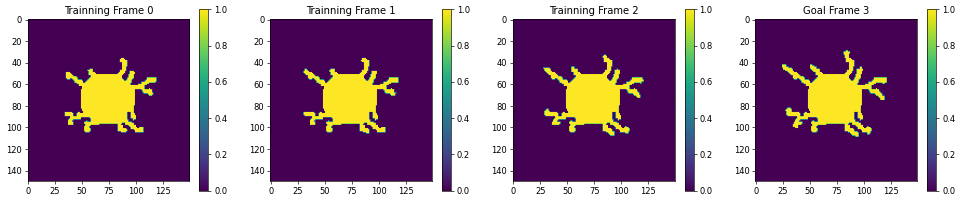

In [4]:
print(x_train.shape)
data_choice = np.random.choice(range(len(x_train)), size=1)[0]
print(data_choice)
channel = 0
plt.figure(figsize=(20, 4), dpi=60)
for i in range(numFrames):
    plt.subplot(1,numFrames+1,i+1)
    plt.imshow(x_train[data_choice,i,:,:,channel])
    plt.colorbar()
    plt.title(f"Trainning Frame {i}")

plt.subplot(1,numFrames+1,numFrames+1)
plt.imshow(y_train[data_choice,0,:,:,channel])
plt.colorbar()
plt.title(f"Goal Frame {numFrames}")

In [5]:
# def sum_filter_python(phi):
#     phi = phi.numpy()
#     Nx = phi.shape[0]
#     Ny = phi.shape[1]
#     phi = np.round(phi)

#     phi_sum = np.zeros([Nx,Ny])
#     for i in range(5,Nx-4):
#         for k in range(5,Ny-4):
#             for j in range(k-4,k+4+1):
#                 phi_sum[i,k] = phi_sum[i,k] + int(phi[i,k]==phi[i-4,j])*phi[i-4,j] + int(phi[i,k]==phi[i-3,j])*phi[i-3,j] + int(phi[i,k]==phi[i-2,j])*phi[i-2,j] + int(phi[i,k]==phi[i-1,j])*phi[i-1,j] + int(phi[i,k]==phi[i-0,j])*phi[i,j] + int(phi[i,k]==phi[i+1,j])*phi[i+1,j] + int(phi[i,k]==phi[i+2,j])*phi[i+2,j] + int(phi[i,k]==phi[i+3,j])*phi[i+3,j] + int(phi[i,k]==phi[i+4,j])*phi[i+4,j]

#     phi_sum = np.divide(phi,phi_sum)
#     phi_sum[np.isnan(phi_sum)] = 0
#     phi_sum_max = np.amax(np.amax(phi_sum))
#     phi_sum = np.divide(phi_sum,phi_sum_max)

#     phi_sum_temp = phi_sum
#     cutoff = np.percentile(np.reshape(phi_sum_temp,[Nx*Ny,1]),99.97)
#     phi_sum[phi_sum<cutoff] = 0
#     phi_sum[phi_sum!=1] = 0  
#     out = tf.Variable(tf.zeros([Nx,Ny],tf.float64))
#     out.assign(phi_sum)
#     return out

# def highlightZone(tip):
#     [Max_y,Max_x] = np.where(tip==1)
#     size_Max = len(Max_x)
#     Nx, Ny = phi_plot.shape
#     tips = np.zeros([Nx,Ny])
#     temp = np.zeros([Nx,Ny])
#     for l in range(0,size_Max):
#         max_x = Max_x[l]
#         max_y = Max_y[l]
#         for i in range(max_y-2,max_y+2):
#             for j in range(max_x-2,max_x+2):
#                     temp[i,j] = 1
#         tips = tips+temp

#     tips[np.abs(tips)>0] = 1
#     return tips

# def sum_filter_python(phi):
#     [Nx,Ny] = tf.shape(phi)
#     phi = tf.math.round(phi)
#     phi_sum = tf.Variable(tf.zeros([Nx,Ny],tf.float32))
#     for i in range(5,Nx-4):
#         for k in range(5,Ny-4):
#             for j in range(k-4,k+4+1):
#                 phi_sum[i,k].assign(tf.math.add(tf.cast(phi[i,k],tf.float32),tf.multiply(tf.cast(phi[i,k]==phi[i-4,j],tf.float32),phi[i-4,j])))

#     return phi_sum

In [6]:
# function to calculate partial derivatives of the input
def get_deriv(input):
    N1N_input, NN1_input = tf.image.image_gradients(input)
    N2N_input, _ = tf.image.image_gradients(N1N_input)
    _, NN2_input = tf.image.image_gradients(NN1_input)
    LAP_input = tf.math.add(N2N_input,NN2_input)
    return N1N_input, NN1_input, N2N_input, NN2_input, LAP_input

# calculate MSE
def get_MSE_tf(input,goal):
    return tf.math.reduce_mean(tf.square(tf.math.subtract(input, goal)))

def get_MRE_tf(input,goal):
    return tf.math.sqrt(tf.reduce_sum(tf.math.square(input-goal)/(input.shape[0]*input.shape[1])))
    
# PINN - physics-informed loss function for Phase-field neuron growth model
def PINN_loss():
    def loss(y_true, y_pred):
        dt = 0.01*500 # current data sampled per 500 iter (change based on dataset)
        
        # extract variables from ground truth
        true_phi = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        true_tips = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,0,:,:,1],axis=0),axis=3), dtype=tf.float64)
        true_tub = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,0,:,:,2],axis=0),axis=3), dtype=tf.float64)
        true_tempr = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,0,:,:,3],axis=0),axis=3), dtype=tf.float64)
        theta = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,0,:,:,4],axis=0),axis=3), dtype=tf.float64) # Since theta is passed, theta remains the same
        # extract variables from previous iteration (intentionally placed in ground truth so it is easier to access)
        NN_p = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,1,:,:,0],axis=0),axis=3), dtype=tf.float64)
        tub_p = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,1,:,:,2],axis=0),axis=3), dtype=tf.float64)
        tempr_p = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,1,:,:,3],axis=0),axis=3), dtype=tf.float64)
        # extract variables from prediction
        NN_pK = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,-1,:,:,0],axis=0),axis=3), dtype=tf.float64)
        tips_pK = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,-1,:,:,1],axis=0),axis=3), dtype=tf.float64)
        tub_pK = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,-1,:,:,2],axis=0),axis=3), dtype=tf.float64)
        tempr_pK = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,-1,:,:,3],axis=0),axis=3), dtype=tf.float64)

        # calc corresponding partial derivatives
        N1N_p, NN1_p, _, _, LAP_p = get_deriv(NN_p)
        N1N_theta, NN1_theta, _, _, _ = get_deriv(theta)
        _, _, _, _, LAP_tp = get_deriv(tempr_p)
        N1N_tb, NN1_tb, _, _, LAP_tb = get_deriv(tub_p)

        # Temperature residual
        tempr_residual = (3*LAP_tp+4*(NN_pK - NN_p)/dt)*dt + tempr_p - tempr_pK

        # Tubulin residual
        diff_tb = 4*(tf.math.multiply(N1N_p,N1N_tb) + tf.math.multiply(NN1_p,NN1_tb) + tf.math.multiply(NN_p,LAP_tb))
        alph_tb = 0.001*(tf.math.multiply(N1N_p,tub_p) + tf.math.multiply(NN_p,N1N_tb) + tf.math.multiply(NN1_p,tub_p) + tf.math.multiply(NN_p,NN1_tb))
        beta_tb = 0.001*tf.math.multiply(NN_p,tub_p)
        src_tb = tf.math.divide_no_nan(15*tf.math.square(LAP_p),tf.math.reduce_sum(tf.math.square(LAP_p)))
        tub_residual = (diff_tb - alph_tb - beta_tb + src_tb)*dt + tub_p - tub_pK

        # phase field residual
        e = 0.2865*tf.math.atan(10*tf.math.multiply(tf.math.multiply(tips_pK,5*tub_pK-0.1),1-tempr_pK)) # energy equation
        atheta = tf.math.atan2(NN1_p,N1N_p)
        a = 0.04*(1.0+0.1*tf.math.cos(6*(atheta-theta)))
        ap = -0.04*(6*0.1*tf.math.sin(6*(atheta-theta)))
        aap = tf.math.multiply(a,ap)
        a2 = tf.math.square(a)
        a2Lap = tf.math.multiply(a2,LAP_p)
        N1N_aapNN1p, _ = tf.image.image_gradients(tf.math.multiply(aap,NN1_p))
        _, NN1_aapN1Np = tf.image.image_gradients(tf.math.multiply(aap,N1N_p))
        mag_theta = tf.math.sqrt(tf.math.square(N1N_theta) + tf.math.square(NN1_theta))
        dblwll_term = tf.math.multiply(tf.math.multiply(NN_p,1-NN_p),NN_p - 0.5 + e + 6*0.007*mag_theta)
        phi_residual = a2Lap - N1N_aapNN1p + NN1_aapN1Np + dblwll_term - (NN_pK - NN_p) / dt

        # calculate mean of each residual and mse of prediction and ground truth
        residual_mse = tf.math.reduce_mean(phi_residual) + tf.math.reduce_mean(tempr_residual) + tf.math.reduce_mean(tub_residual)
        diff_mse = get_MSE_tf(NN_pK,true_phi) + get_MSE_tf(tips_pK,true_tips) + get_MSE_tf(tempr_pK,true_tempr) + get_MRE_tf(tub_pK,true_tub)
        loss = tf.math.abs(residual_mse) + tf.math.abs(diff_mse)
        
        return loss
    return loss

In [7]:
from tensorflow.keras import layers
inp = layers.Input(shape=(x_train.shape[1:]))

# Separable Convolution Encoding
x0 = layers.TimeDistributed(layers.SeparableConv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    depth_multiplier=1,
    padding="valid",
    activation="relu",
))(inp)
x1 = layers.TimeDistributed(layers.SeparableConv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    depth_multiplier=1,
    padding="valid",
    activation="relu",
))(x0)
# recurrent cell, 5 time step to 1 time step
x2 = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=False,
    activation="relu",
    # recurrent_dropout=drop_rate,
)(x1)
x2 = tf.expand_dims(x2,axis=1)

# decoding for phi channel
phi1 = x2
phi2 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
))(phi1)
phi3 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(4, 4), # modified for 150 size
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
))(phi2)

# decoding for tips channel
tip1 = phi3
# tip1 = tf.expand_dims(tf.expand_dims(inp[:,-1,:,:,1],axis=1),axis=4)
tip2 = layers.TimeDistributed(layers.Conv2D(
    filters=1,
    kernel_size=(6, 6),
    strides = (1, 1),
    padding="same",
    activation="sigmoid",
))(tip1)
# tip3 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=1,
#     kernel_size=(6, 6),
#     strides = (1, 1),
#     padding="same",
#     activation="sigmoid",
# ))(tip2)

# decoding for tublin channel
tub1 = x2
tub2 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
    use_bias=True,
))(tub1)
tub3 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(4, 4),
    strides = (2, 2),
    padding="valid",
    activation="relu",
    use_bias=True,
))(tub2)
tub4 = tf.math.multiply(phi3,tub3)

# decoding for temperature channel
phi_pre = tf.expand_dims(tf.expand_dims(inp[:,-1,:,:,0],axis=1),axis=4)
phi_diff = phi3 - phi_pre
tempr1 = x2
tempr2 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(tempr1)
tempr3 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(4, 4),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(tempr2)
tempr3 = tf.concat([tempr3,phi_diff],axis=4)
tempr4 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (1, 1),
    padding="same",
    activation="relu",
))(tempr3)

# passing theta (no change)
theta1 = tf.expand_dims(tf.expand_dims(inp[:,0,:,:,-1],axis=1),axis=4)

# concat all to generate output
out = tf.concat([phi3,tip2,tub4,tempr4,theta1],axis=4)

2022-07-20 22:17:05.492417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 22:17:05.492589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 22:17:05.492691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 22:17:05.492933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 22:17:05.493047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [8]:
model = keras.models.Model(inp, out)
model.compile(
    loss=PINN_loss(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4))
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 150, 150  0           []                               
                                , 5)]                                                             
                                                                                                  
 time_distributed (TimeDistribu  (None, 3, 73, 73, 6  509        ['input_1[0][0]']                
 ted)                           4)                                                                
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 3, 35, 35, 1  9920       ['time_distributed[0][0]']       
 buted)                         28)                                                           

In [9]:
test = False

if test == True:
    model = keras.models.load_model('./saved_model/model_conv_lstm_test_21', custom_objects={'loss': PINN_loss()})
else: 
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=15)
    epochs = 1000
    batch_size = 1
    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping, reduce_lr],
        )
    model.save('./saved_model/model_conv_lstm_test_21') 

Epoch 1/1000


2022-07-20 22:17:10.436404: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_189/input/_551' -> 'gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_189/gradient_tape/model/conv_lstm2d/while/gradients/AddN', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_2' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_5', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/clip_by_value' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_3', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/convolution_6' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_4', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/clip_by_value_2' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_5'}.
2022-07-20 22

1291/1292 [============================>.] - ETA: 0s - loss: 1.3293

2022-07-20 22:17:39.628436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/convolution_7' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_6', 'Func/model/conv_lstm2d/while/body/_1/input/_68' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_2', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/Relu_1' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_5'}.


1292/1292 [==============================] - 35s 23ms/step - loss: 1.3286 - val_loss: 0.5573 - lr: 1.0000e-04
Epoch 2/1000
1292/1292 [==============================] - 29s 23ms/step - loss: 0.5508 - val_loss: 1.6211 - lr: 1.0000e-04
Epoch 3/1000
1292/1292 [==============================] - 29s 23ms/step - loss: 0.5133 - val_loss: 0.3628 - lr: 1.0000e-04
Epoch 4/1000
1292/1292 [==============================] - 30s 23ms/step - loss: 0.4207 - val_loss: 0.3019 - lr: 1.0000e-04
Epoch 5/1000
1292/1292 [==============================] - 30s 23ms/step - loss: 0.3666 - val_loss: 0.3092 - lr: 1.0000e-04
Epoch 6/1000
1292/1292 [==============================] - 30s 23ms/step - loss: 0.3541 - val_loss: 0.5798 - lr: 1.0000e-04
Epoch 7/1000
1292/1292 [==============================] - 30s 23ms/step - loss: 0.2969 - val_loss: 0.3676 - lr: 1.0000e-04
Epoch 8/1000
1292/1292 [==============================] - 29s 22ms/step - loss: 0.3151 - val_loss: 0.2516 - lr: 1.0000e-04
Epoch 9/1000
1292/1292 [=====

INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_test_21/assets


INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_test_21/assets


Random case: 13


Plotting and Saving figures ...:   0%|          | 0/64 [00:00<?, ?it/s]

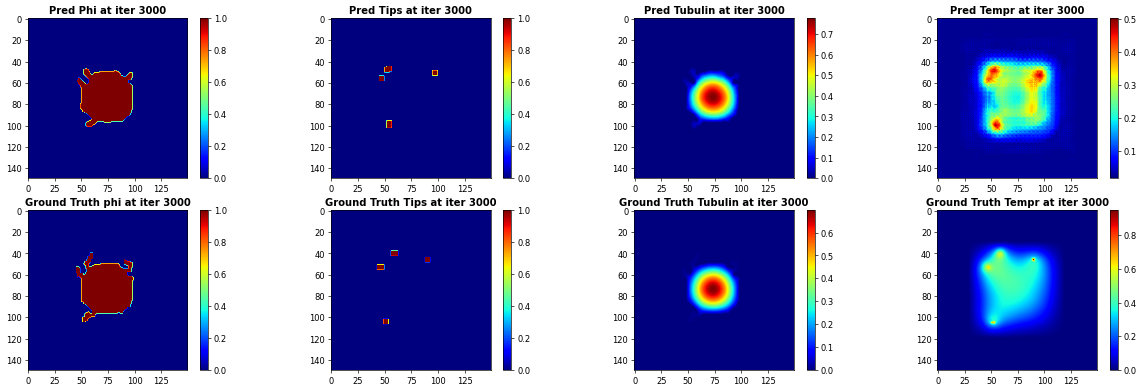

Plotting and Saving figures ...:   2%|▏         | 1/64 [00:01<01:22,  1.31s/it]

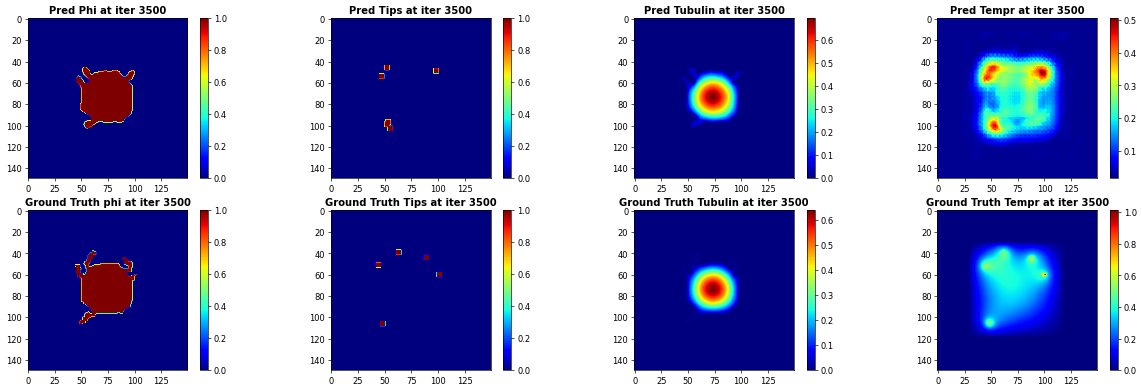

Plotting and Saving figures ...:   3%|▎         | 2/64 [00:02<01:13,  1.19s/it]

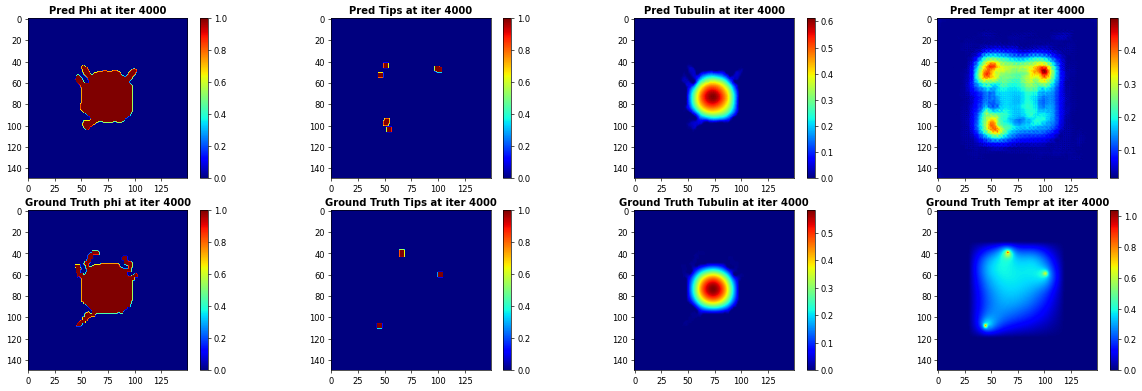

Plotting and Saving figures ...:   5%|▍         | 3/64 [00:03<01:05,  1.08s/it]

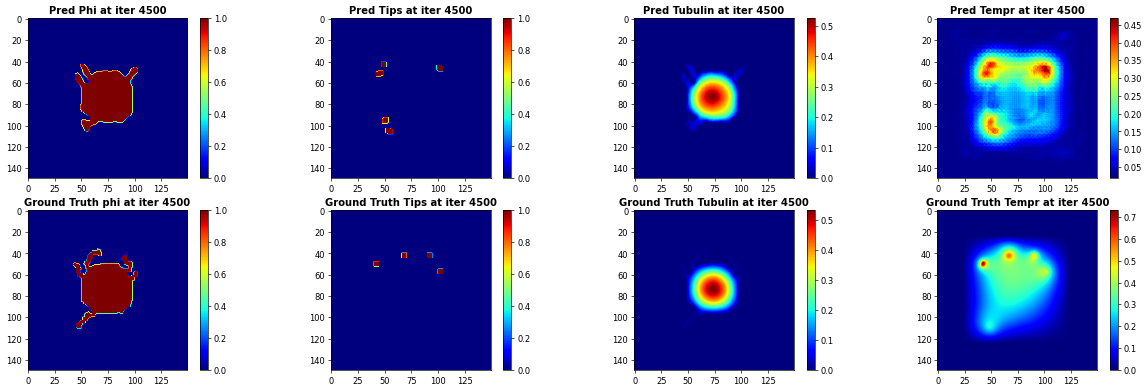

Plotting and Saving figures ...:   6%|▋         | 4/64 [00:04<00:56,  1.05it/s]

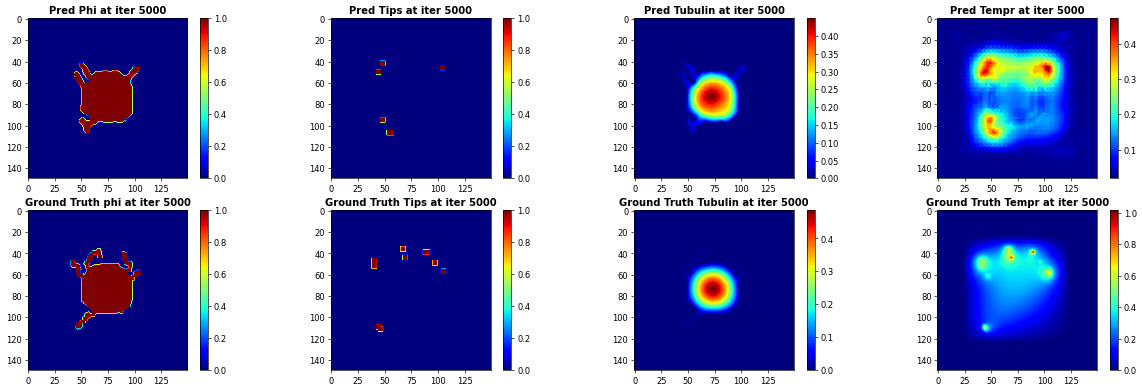

Plotting and Saving figures ...:   8%|▊         | 5/64 [00:04<00:51,  1.14it/s]

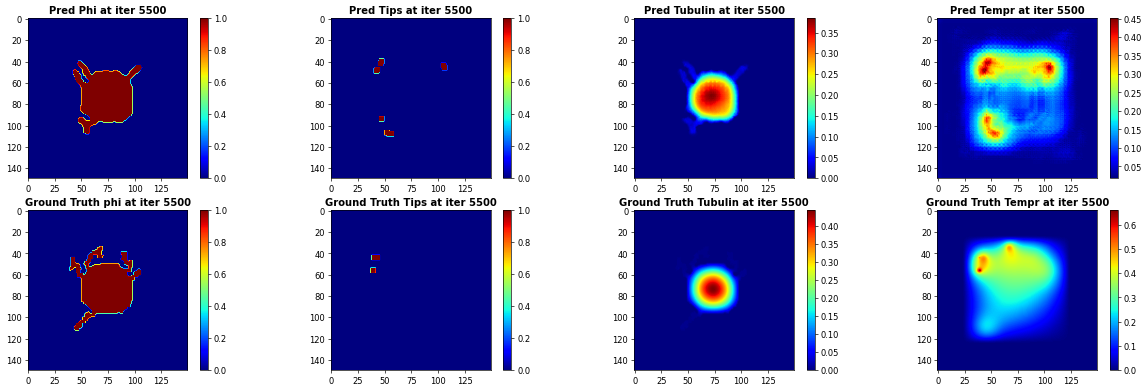

Plotting and Saving figures ...:   9%|▉         | 6/64 [00:05<00:51,  1.12it/s]

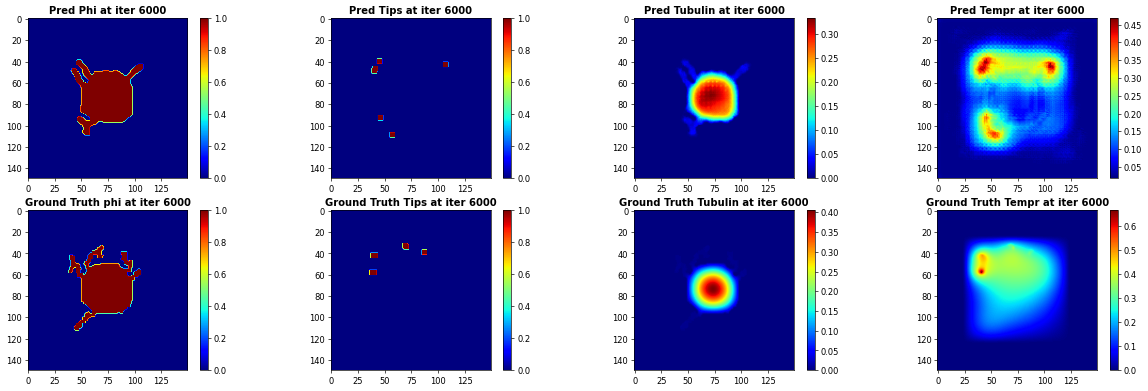

Plotting and Saving figures ...:  11%|█         | 7/64 [00:06<00:48,  1.18it/s]

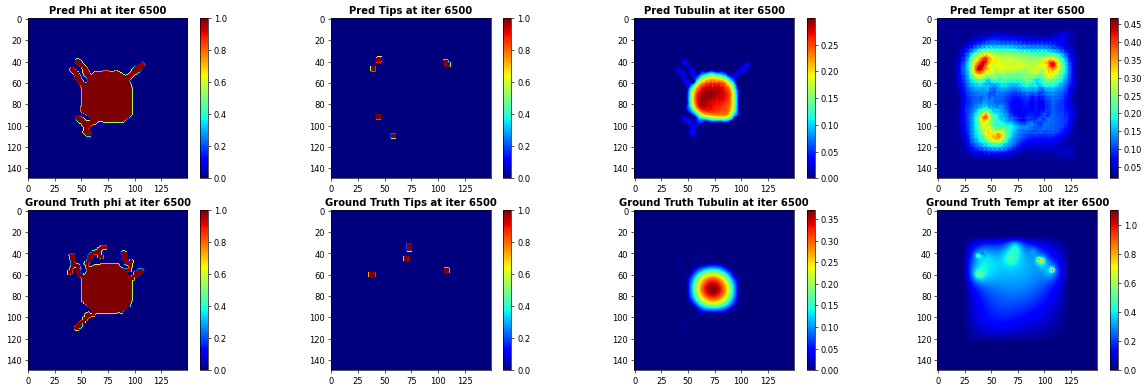

Plotting and Saving figures ...:  12%|█▎        | 8/64 [00:07<00:45,  1.23it/s]

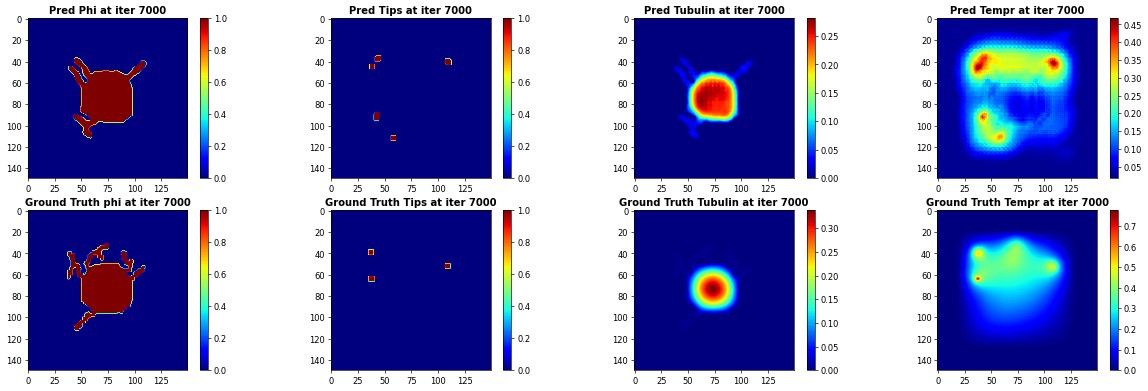

Plotting and Saving figures ...:  14%|█▍        | 9/64 [00:08<00:46,  1.18it/s]

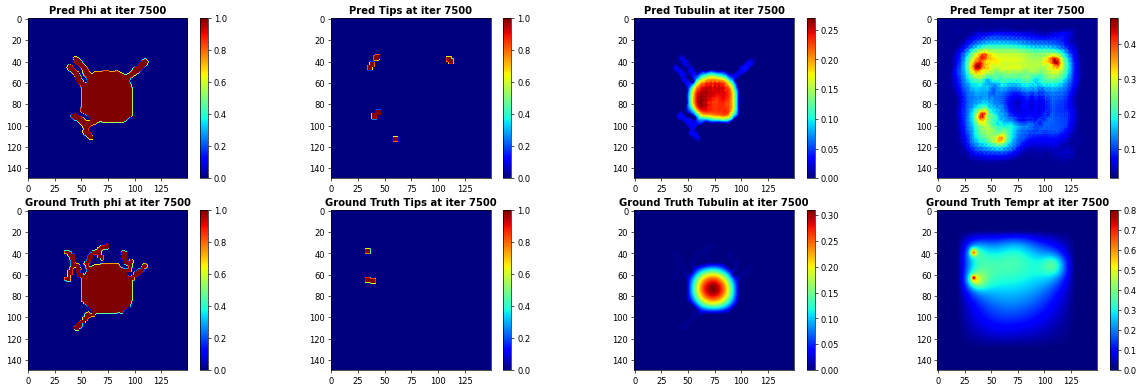

Plotting and Saving figures ...:  16%|█▌        | 10/64 [00:08<00:43,  1.23it/s]

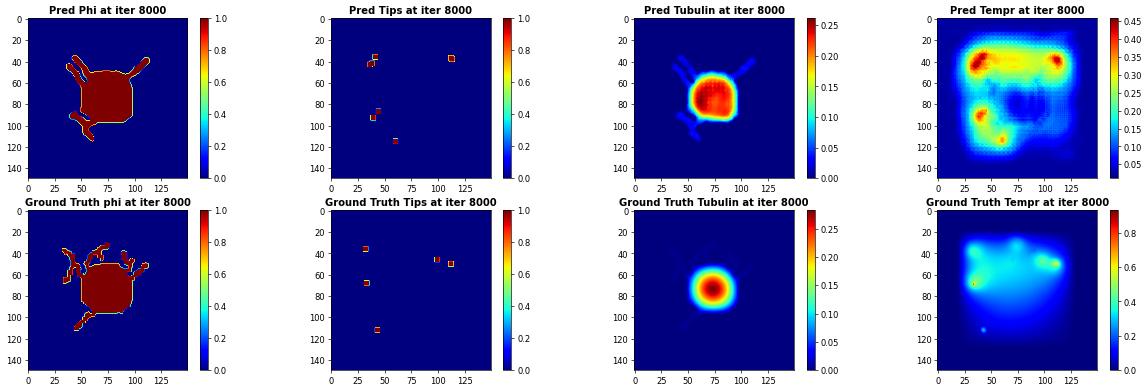

Plotting and Saving figures ...:  17%|█▋        | 11/64 [00:09<00:41,  1.26it/s]

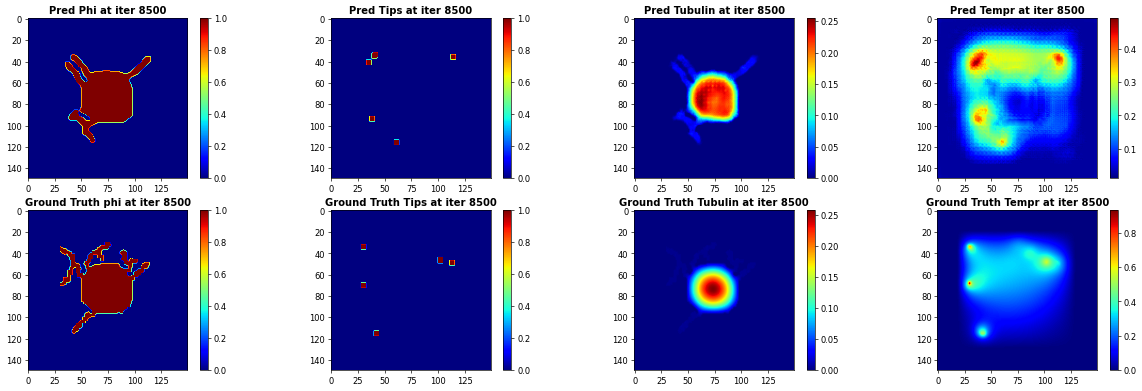

Plotting and Saving figures ...:  19%|█▉        | 12/64 [00:10<00:42,  1.21it/s]

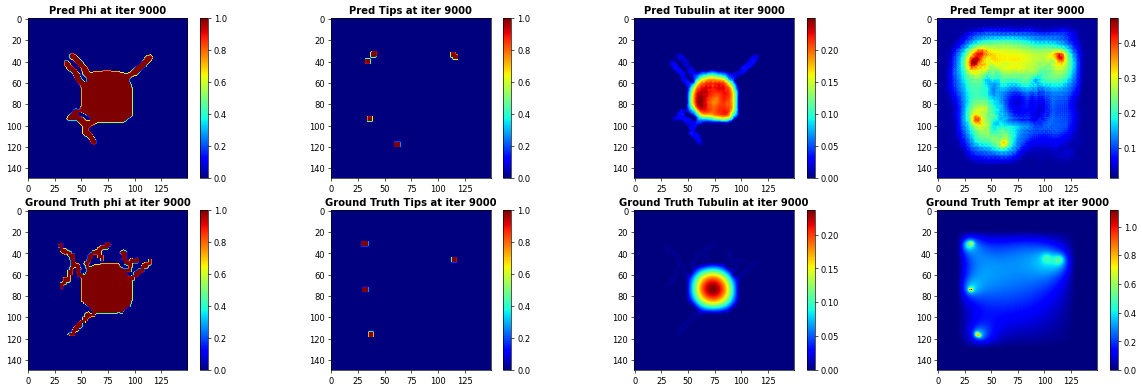

Plotting and Saving figures ...:  20%|██        | 13/64 [00:11<00:40,  1.25it/s]

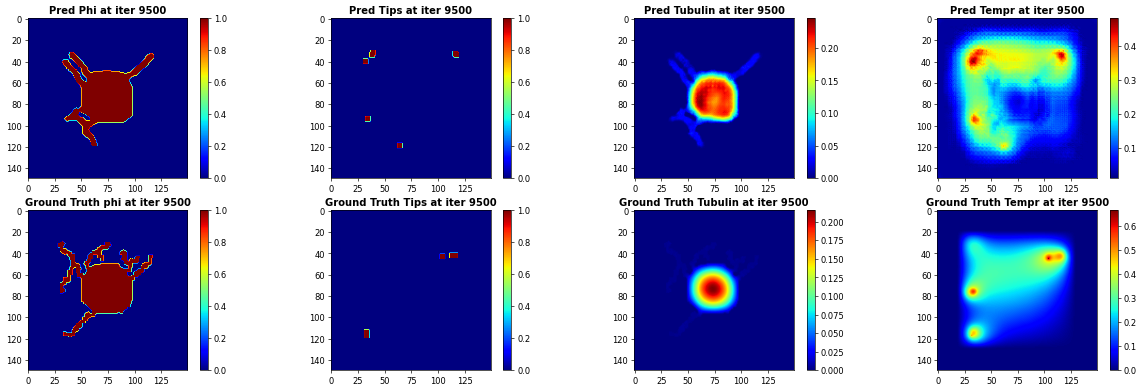

Plotting and Saving figures ...:  22%|██▏       | 14/64 [00:12<00:39,  1.27it/s]

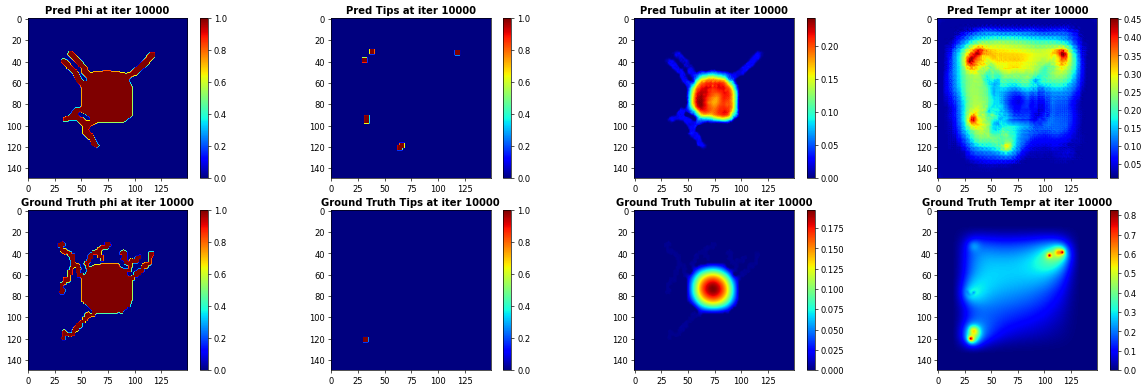

Plotting and Saving figures ...:  23%|██▎       | 15/64 [00:13<00:40,  1.20it/s]

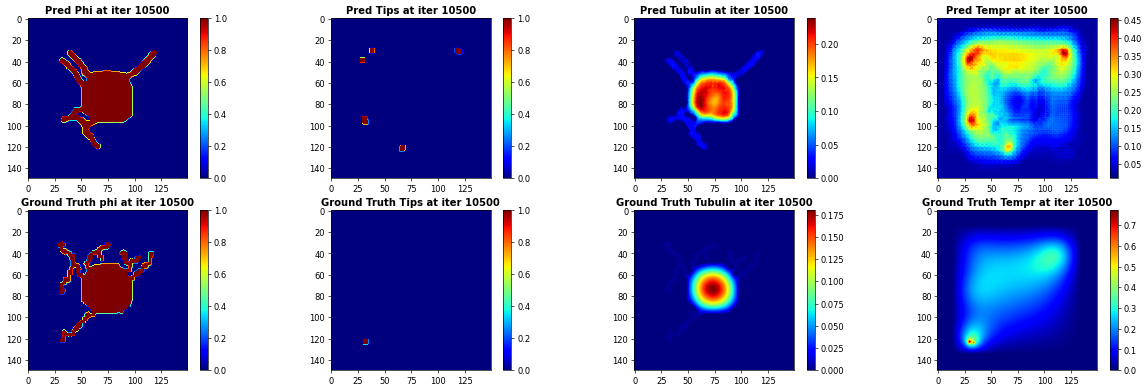

Plotting and Saving figures ...:  25%|██▌       | 16/64 [00:13<00:39,  1.22it/s]

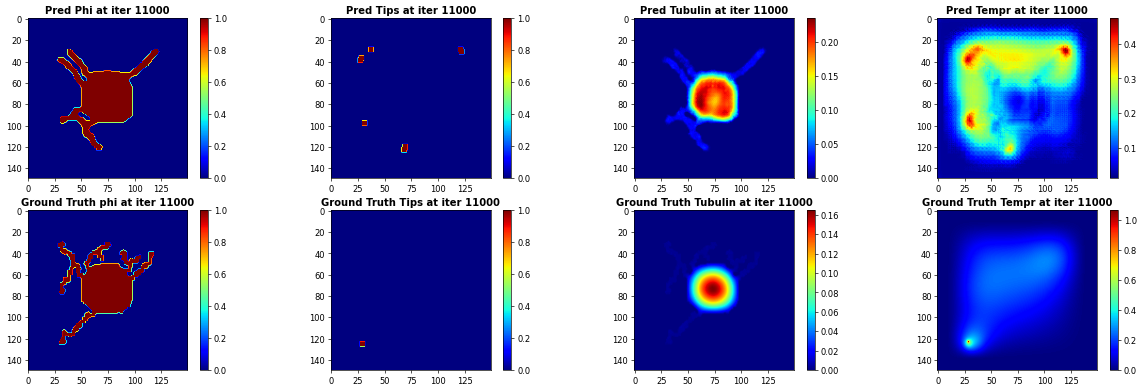

Plotting and Saving figures ...:  27%|██▋       | 17/64 [00:14<00:40,  1.16it/s]


IndexError: index 22 is out of bounds for axis 0 with size 22

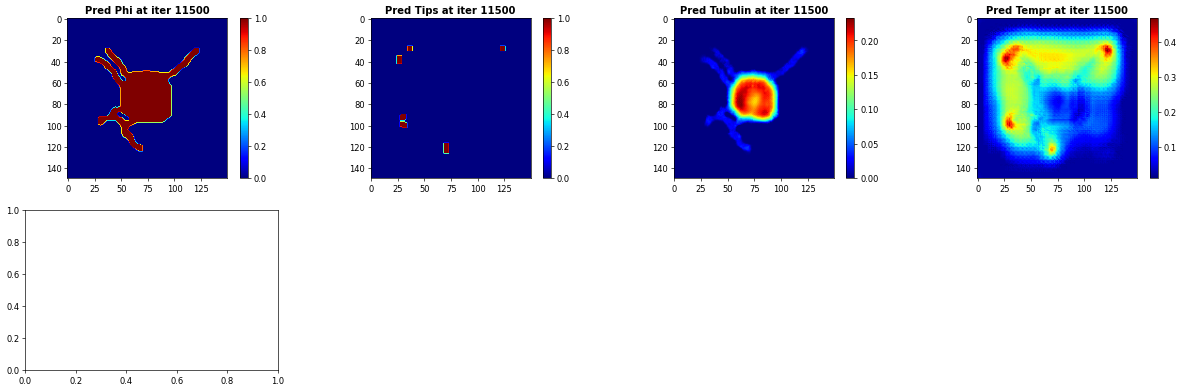

In [14]:
import copy
# start matlab engine, requires valid installation of matlab and matlab.engine library
import matlab.engine
eng = matlab.engine.start_matlab()
s = eng.genpath('Matlab_algorithm')
eng.addpath(s, nargout=0)

# calc mre between pred and goal
def get_mre(pred,goal):
    return np.sqrt(np.sum(np.square(pred-goal)/(pred.shape[0]*pred.shape[1])))

def push(input, cutoff):
    max_input = np.amax(input)
    output = copy.copy(input)
    output[input>cutoff*max_input] = 1
    output[input<=cutoff*max_input] = 0
    return output

# generating intial 5 frame input for predictions
rand_case = np.random.randint((len(val_dataset)))
print(f"Random case: {rand_case}")
example_x = val_dataset[rand_case,:,:,:,0:5]
x_in = np.expand_dims(example_x[0:numFrames,...],axis=0)

# loop to continuously make prediction (based on lastest 5 frames)
for i in tqdm(range(64), desc="Plotting and Saving figures ..."):
    iter = (i+1)*500+2500
    # prediction
    new_prediction = model.predict(x_in,verbose="0")
    phi = push(new_prediction[0,0,:,:,0],0.3)
    # phi = new_prediction[0,0,:,:,0]
    tips = eng.generate_tips_for_python(matlab.double(np.array(phi).astype('float64')),5000) # calc tips using matlab algorithm
    # tips = new_prediction[0,0,:,:,1]
    tub = new_prediction[0,0,:,:,2]
    tempr = new_prediction[0,0,:,:,3]
    theta = new_prediction[0,0,:,:,4]

    # plot prediction
    plt.figure(figsize=(25, 12), dpi=60)
    plt.gcf().set_facecolor("white")
    plt.subplot(3,4,1)
    plt.imshow(phi, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Phi at iter {iter}", fontweight='bold')
    plt.subplot(3,4,2)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tips at iter {iter}", fontweight='bold')
    plt.subplot(3,4,3)
    plt.imshow(tub, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tubulin at iter {iter}", fontweight='bold')
    plt.subplot(3,4,4)
    plt.imshow(tempr, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tempr at iter {iter}", fontweight='bold')
    # plot ground truth
    plt.subplot(3,4,5)
    plt.imshow(example_x[i+5,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth phi at iter {iter}", fontweight='bold')
    plt.subplot(3,4,6)
    plt.imshow(example_x[i+5,:,:,1], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tips at iter {iter}", fontweight='bold')
    plt.subplot(3,4,7)
    plt.imshow(example_x[i+5,:,:,2], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tubulin at iter {iter}", fontweight='bold')
    plt.subplot(3,4,8)
    plt.imshow(example_x[i+5,:,:,3], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tempr at iter {iter}", fontweight='bold')
    # # calc mean relative error
    # mre_phi = get_mre(phi,example_x[i+5,:,:,0])
    # mre_tips = get_mre(tips,example_x[i+5,:,:,1])
    # mre_tempr = get_mre(tempr,example_x[i+5,:,:,2])
    # mre_tub = get_mre(tub,example_x[i+5,:,:,3])
    # mre_theta = get_mre(theta,example_x[i+5,:,:,4])
    # # plot error
    # plt.subplot(3,4,9)
    # plt.imshow(phi-example_x[i+5,:,:,0], cmap='jet')
    # plt.colorbar()
    # plt.title(f"Absolute phi at iter {iter}", fontweight='bold')
    # plt.xlabel(f"MRE error: {mre_phi}")
    # plt.subplot(3,4,10)
    # plt.imshow(tips-example_x[i+5,:,:,1], cmap='jet')
    # plt.colorbar()
    # plt.title(f"Absolute Tips at iter {iter}", fontweight='bold')
    # plt.xlabel(f"MRE error: {mre_tips}")
    # plt.subplot(3,4,11)
    # plt.imshow(tub-example_x[i+5,:,:,2], cmap='jet')
    # plt.colorbar()
    # plt.title(f"Absolute Tubulin at iter {iter}", fontweight='bold')
    # plt.xlabel(f"MRE error: {mre_tempr}")
    # plt.subplot(3,4,12)
    # plt.imshow(tempr-example_x[i+5,:,:,3], cmap='jet')
    # plt.colorbar()
    # plt.title(f"Absolute Tempr at iter {iter}", fontweight='bold')
    # plt.xlabel(f"MRE error: {mre_tub}")
    # save fig
    # plt.savefig(f"gif/{iter:05d}.png")
    plt.show()

    # update prediction for later use as input (shifting)
    tmp_var = copy.copy(new_prediction)
    tmp_var[0,-1,:,:,0] = phi
    tmp_var[0,-1,:,:,1] = tips
    tmp = np.zeros(x_in.shape)
    for j in range(numFrames-1):
        tmp[0,j,...] = x_in[0,j+1,...]
    tmp[0,-1,:,:,:] = tmp_var
    x_in = tmp

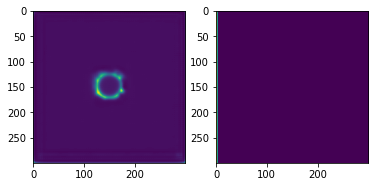

In [ ]:
# phi = push(new_prediction[0,0,:,:,0],0.5)
phi = new_prediction[0,0,:,:,0]
# phi = example_x[i+5,:,:,0]
plt.subplot(1,2,1)
plt.imshow(phi)
plt.subplot(1,2,2)
tips = eng.generate_tips_for_python(matlab.double(np.array(phi).astype('float64')),5000) # calc tips using matlab algorithm
plt.imshow(tips)